In [19]:
%%capture
!pip install pandas
!pip install spacy # for auto labeling 
!python -m spacy download en_core_web_sm
!pip install networkx 
!pip install matplotlib
!pip install scipy

In [17]:
import pandas as pd

# Load the dataset
path = '/mnt/f/datasets/data.csv'
df = pd.read_csv(path)

# Display the total number of articles
print(f"Total articles available: {len(df)}")

# Sample 200 articles randomly
sampled_df = df.sample(n=200, random_state=42)

# Display the first few entries
sampled_df.head() 

Total articles available: 105375


,article_id,source_id,source_name,author,title,description,url,url_to_image,published_at,content,category,full_content
43325,63642,NaN,The Week Magazine,theweekonlineeditorsuk@futurenet.com (Keumars ...,Young teen wins top science prize for soap tha...,Memory of Ethiopian workers out in the sun ins...,https://theweek.com/science/young-teen-wins-to...,https://cdn.mos.cms.futurecdn.net/zAhQwHDgPJoS...,2023-10-27 09:38:42.000000,"A 14-year-old boy has been named ""America's to...",Ethiopia,NaN
19051,13370,NaN,Boing Boing,Rob Beschizza,"Vehicular homicide suspect who ""reeked of alco...","Ting Ye, 26, ""reeked of alcohol"" when she was ...",https://boingboing.net/2023/10/30/vehicular-ho...,https://i0.wp.com/boingboing.net/wp-content/up...,2023-10-30 12:09:58.000000,"Ting Ye, 26, ""reeked of alcohol"" when she was ...",United States,"Ting Ye, 26, ""reeked of alcohol"" when she was ..."
45314,69158,NaN,Eater,Martha Cheng,The Pastry Chefs Defining Restaurant Dessert R...,"Hannah Ziskin, Tavel Bristol-Jospeh, Kelly Nam...",https://www.eater.com/23919112/restaurant-past...,https://cdn.vox-cdn.com/thumbor/EdI5vEOW1_S11V...,2023-10-18 19:09:20.000000,Kelly Nam plates a dessert at New York City’s ...,Guyana,NaN
5671,97723,NaN,Boing Boing,Jennifer Sandlin,"Flula Borg hilarious deconstructs that weird ""...","Ok, one last Halloween post and I'll abandon t...",https://boingboing.net/2023/11/02/flula-borg-h...,https://i0.wp.com/boingboing.net/wp-content/up...,2023-11-02 09:02:40.000000,"Ok, one last Halloween post and I'll abandon t...",History,"Ok, one last Halloween post and I'll abandon t..."
78957,84216,NaN,Bangkok Post,Prasit Tangprasert,Korat zoo welcomes new member - sun bear,Nakhon Ratchasima Zoo has a new member - a one...,https://www.bangkokpost.com/thailand/general/2...,https://static.bangkokpost.com/media/content/2...,2023-10-05 03:50:00.000000,Nakhon Ratchasima Zoo has a new member - a one...,Myanmar,NaN


In [3]:
# NER - Named Entity Recognition 
print(sampled_df.columns)

Index(['article_id', 'source_id', 'source_name', 'author', 'title',
       'description', 'url', 'url_to_image', 'published_at', 'content',
       'category', 'full_content'],
      dtype='object')


In [4]:
# how many entries are available in full_content? 114  
sampled_df[['title', 'description', 'content', 'full_content']].notnull().sum()

title           200
description     200
content         200
full_content    114
dtype: int64

In [5]:
# use 114 full_content entries for now 
# use spacy for auto labeling 
import spacy

# Load English NER model
nlp = spacy.load("en_core_web_sm")

# Apply NER to each article
def extract_ner(text):
    doc = nlp(text)
    return [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]

# Filter non-null content
valid_articles = sampled_df[sampled_df['full_content'].notnull()]['full_content']

# Extract entities from each article
labeled_data = []
for text in valid_articles:
    entities = extract_ner(text)
    labeled_data.append((text, {"entities": [(start, end, label) for _, start, end, label in entities]}))


In [6]:
# labeled examples to verify structure 
for i in range(3):  # Show first 3 samples
    text, annotations = labeled_data[i]
    print("Text snippet:", text[:200])  # Print first 200 characters
    print("Entities:", annotations["entities"])
    print()


Text snippet: Ting Ye, 26, "reeked of alcohol" when she was pulled from the driver's seat of a 100MPH rollover crash that killed her passenger, Yabao Liu. While police in Washington state twiddled their thumbs, she
Entities: [(0, 7, 'PERSON'), (9, 11, 'DATE'), (81, 87, 'CARDINAL'), (130, 139, 'PERSON'), (157, 167, 'GPE'), (220, 245, 'ORG'), (249, 256, 'GPE'), (289, 294, 'GPE'), (296, 298, 'PERSON'), (351, 386, 'ORG'), (396, 399, 'ORG'), (538, 548, 'PERSON'), (554, 569, 'ORG'), (576, 591, 'ORG'), (601, 603, 'PERSON'), (608, 611, 'PERSON'), (621, 626, 'GPE'), (628, 630, 'PERSON'), (671, 676, 'PERSON'), (733, 738, 'GPE'), (743, 760, 'GPE'), (855, 868, 'PERSON'), (880, 890, 'PERSON'), (902, 913, 'PERSON'), (925, 934, 'PERSON')]

Text snippet: Ok, one last Halloween post and I'll abandon the topic until next year. As you're munching on your candy haul, watch this funnyvideocreated by German actor, comedian, and musicianFlula Borg. He begins
Entities: [(4, 7, 'CARDINAL'), (8, 22, 'DATE'), (6

In [7]:
import IPython
print(IPython.__file__)


/home/max/krag-env/lib/python3.11/site-packages/IPython/__init__.py


In [8]:
from IPython.display import HTML, display
from spacy import displacy
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

# Get HTML manually, disable Jupyter output integration
html = displacy.render(doc, style="ent", jupyter=False)
display(HTML(html))




### What This Code Does

This cell uses spaCy's `en_core_web_sm` model to extract named entities from a sentence.

- It identified:
  - `Apple` as an **organization (ORG)**
  - `U.K.` as a **geopolitical entity (GPE)**
  - `$1 billion` as a **monetary value (MONEY)**

These extracted entities will be used to form (subject, predicate, object) triples,
which are later integrated into the RAG system's prompt for improved accuracy.

This confirms that our NER pipeline is working correctly and ready for scale-up.


In [9]:
# Filter to non-null content
texts = sampled_df['full_content'].dropna().tolist()

# Extract entities and relationships
def extract_relationships(doc):
    relationships = []
    for sent in doc.sents:
        root = sent.root
        subject = None
        obj = None
        for child in root.children:
            if child.dep_ == "nsubj":
                subject = child
            if child.dep_ in ["dobj", "pobj"]:
                obj = child
        if subject and obj:
            relationships.append((subject.text, root.lemma_, obj.text))
    return relationships

all_triples = []

for text in texts:
    doc = nlp(text)
    triples = extract_relationships(doc)
    all_triples.extend(triples)


In [11]:
# build KG with network X 
import networkx as nx

G = nx.DiGraph()

for subj, pred, obj in all_triples:
    G.add_edge(subj, obj, relation=pred)


In [12]:
# Print a few edges with relations
for u, v, d in list(G.edges(data=True))[:10]:
    print(f"{u} —[{d['relation']}]-> {v}")


I —[find]-> thispiecein
I —[find]-> anything
I —[play]-> cricket
I —[order]-> city
I —[have]-> pleasure
I —[craft]-> products
I —[begin]-> career
I —[craft]-> websites
I —[discover]-> dimension
I —[describe]-> brand


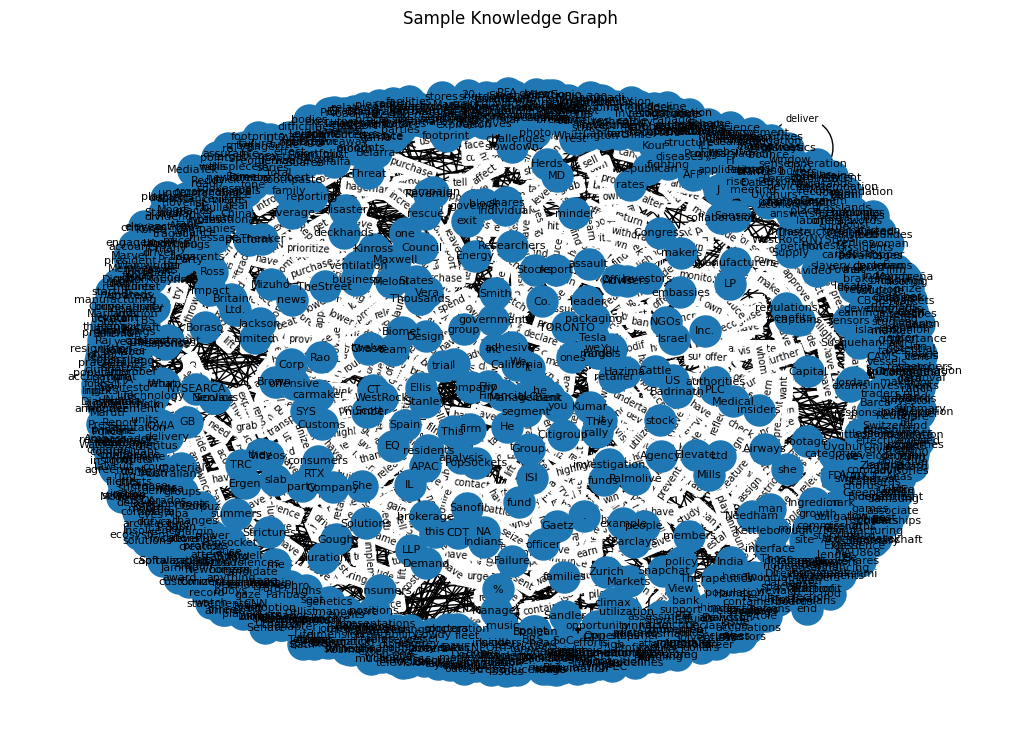

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8)
edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
plt.title("Sample Knowledge Graph")
plt.show()


This is our knowledge graph of the news articles. We can see the words here 